<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#High-Frequency-Trading-&amp;-2010-Market-Flash-Crash" data-toc-modified-id="High-Frequency-Trading-&amp;-2010-Market-Flash-Crash-1">High Frequency Trading &amp; 2010 Market Flash Crash</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1.2">Methodology</a></span></li><li><span><a href="#Packages-and-Functions" data-toc-modified-id="Packages-and-Functions-1.3">Packages and Functions</a></span></li><li><span><a href="#Data-Size-and-Exploration" data-toc-modified-id="Data-Size-and-Exploration-1.4">Data Size and Exploration</a></span></li></ul></li><li><span><a href="#OpenMP-Approach-on-Stampede2" data-toc-modified-id="OpenMP-Approach-on-Stampede2-2">OpenMP Approach on Stampede2</a></span><ul class="toc-item"><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-2.1">Data Processing</a></span></li><li><span><a href="#Performance-Metrics" data-toc-modified-id="Performance-Metrics-2.2">Performance Metrics</a></span></li><li><span><a href="#Daily-Messages-Volume" data-toc-modified-id="Daily-Messages-Volume-2.3">Daily Messages Volume</a></span></li><li><span><a href="#Benchmarks---May-2010---Dataset" data-toc-modified-id="Benchmarks---May-2010---Dataset-2.4">Benchmarks - May 2010 - Dataset</a></span></li></ul></li><li><span><a href="#Spark/Hadoop-Approach-on-Wrangler" data-toc-modified-id="Spark/Hadoop-Approach-on-Wrangler-3">Spark/Hadoop Approach on Wrangler</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notebook-Spark-Setup" data-toc-modified-id="Notebook-Spark-Setup-3.0.1">Notebook Spark Setup</a></span></li></ul></li></ul></li></ul></div>

# High Frequency Trading & 2010 Market Flash Crash

**Jose Luis Rodriguez**

**COMP 464 High Performance Computing ** 

**Loyola University Chicago**

## Introduction 

As computational capabilities continue to grow exponentially and financial markets around the world are increasingly dependable on automated systems it is worth to spend some time analysis the market depth data of the weeks leading to and the day of May 6, 2010 to have a better understanding of market behavior during this high volatility period and to compare some of this project findings with official report to congress from the CFTC and SEC. The data used in this project is from CME Group and corresponds to market depth transactions in milliseconds of the E-Mini S\&P 500 futures and options contracts. 

## Methodology

The market depth data that the CME Group provides contains all market data messages required to recreate the order book (list of orders that a trading firm uses to record the interest of buyers and sellers in a particular financial instrument.) each message contains between five to ten orders deep in futures markets and three orders deep in options markets this data is time stamped to the millisecond allowing for an in depth analysis of the price movement.

In order to process the large volume of transactions (millions of transactions per week) and the goal is to compute daily, hourly, minute, seconds, millisecond volume and other data metrics it is necessary to implement statistical operations such as distributions, average in parallel as well as filtering map-reduce type jobs are ideal for type of task as the nature of the data (independent transactions) allows for parallel processing in most cases.

## Packages and Functions 
The following packages and functions are common python packages.

In [94]:
import os
import time
import pandas as pd
from datetime import datetime
from collections import OrderedDict
from matplotlib.dates import DateFormatter
from matplotlib.dates import DateFormatter
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display_html

def display(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def plot_benchmarks(metrics):
    X = metrics['threads']
    read_time = metrics['read_time']
    search_time = metrics['search_time']
    volume_time = metrics['volume_time']

    # plot with various axes scales
    plt.figure(figsize=(15,15))
    
    # PLOT-1A
    plt.subplot(221)
    plt.plot(X, search_time,color='blue')
    plt.xticks(X)
    #plt.xscale('log')
    plt.title('tagSearch Algorithm')
    
    # PLOT-1B
    plt.subplot(222)
    plt.plot(X, read_time,color='orange')
    plt.xticks(X)
    plt.title('readFile Algorithm')

    # PLOT-2A
    plt.subplot(223)
    plt.plot(X, volume_time,color='green')
    plt.xticks(X)    
    #plt.xscale('log')
    plt.title('dateVolume Algorithm')

    # PLOT-2B
    plt.subplot(224)
    plt.plot(X, search_time,color='blue')
    plt.plot(X, read_time,color='orange')
    plt.plot(X, volume_time,color='green')
    plt.xticks(X)
    plt.title('Algorithms Performance')

    plt.subplots_adjust(top=0.95, bottom=0.10, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

    plt.show()
    
def benchmarks(metrics):
    X = metrics['threads']
    read_time = (metrics['read_time']/metrics['read_time'][0])/X
    search_time = (metrics['search_time']/metrics['search_time'][0])/X
    volume_time = (metrics['volume_time']/metrics['volume_time'][0])/X

    # plot with various axes scales
    plt.figure(figsize=(15,15))
    
    
    
    # PLOT-1A
    plt.subplot(221)
    plt.plot(X, search_time,color='blue')
    plt.xticks(X)
    plt.xticks(X, list(X))
    plt.title('tagSearch Efficiency Algorithm')
    
    # PLOT-1B
    plt.subplot(222)
    plt.plot(X, read_time,color='orange')
    plt.xticks(X, list(X))
    plt.title('readFile Efficiency Algorithm')

    # PLOT-2A
    plt.subplot(223)
    plt.plot(X, volume_time,color='green')
    plt.xticks(X, list(X))
    plt.title('dateVolume Efficiency Algorithm')

    # PLOT-2B
    plt.subplot(224)
    plt.plot(X, search_time,color='blue')
    plt.plot(X, read_time,color='orange')
    plt.plot(X, volume_time,color='green')
    plt.xticks(X, list(X))
    plt.title('Algorithms Performance')

    plt.subplots_adjust(top=0.95, bottom=0.10, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

    plt.show()

## Data Size and Exploration  

In [131]:
%%bash
ls -la -h $DATA/data/05/ | grep -o "jlroo .*." |  tail -n +3

jlroo G-817104  27G Dec  3 19:59 XCME_MD_ES_20100503_20100507
jlroo G-817104  23G Dec  3 20:00 XCME_MD_ES_20100510_20100514
jlroo G-817104  31G Dec  3 20:00 XCME_MD_ES_20100517_20100521
jlroo G-817104  21G Dec  3 19:58 XCME_MD_ES_20100524_20100528
jlroo G-817104  16G Dec  3 19:58 XCME_MD_ES_20100531_20100604


In [132]:
%%bash
ls -la -h $DATA/data/12/ | grep -o "jlroo .*." |  tail -n +3

jlroo G-817104  13G Dec  3 20:00 XCME_MD_ES_20101206_20101210
jlroo G-817104  12G Dec  3 20:01 XCME_MD_ES_20101213_20101217
jlroo G-817104 4.8G Dec  3 20:00 XCME_MD_ES_20101220_20101224
jlroo G-817104 3.9G Dec  3 20:01 XCME_MD_ES_20101227_20101231


In [133]:
%%bash
tail -n 10 $WORK/data/12/XCME_MD_ES_20101227_20101231

1128=99=15635=X49=CME34=1605832952=2010123122125073375=20101231268=1279=022=848=28303464=2010123183=7180107=ESZ1 P0960269=6270=3100273=221202000286=10010=179
1128=99=15635=X49=CME34=1605833052=2010123122125073375=20101231268=1279=022=848=28303464=2010123183=7181107=ESZ1 P0960269=6270=3110273=221202000286=10110=174
1128=99=15635=X49=CME34=1605833152=2010123122125074375=20101231268=1279=022=848=65264964=2010123183=7099107=ESZ1 P0970269=6270=3275273=221202000286=10010=208
1128=99=15635=X49=CME34=1605833252=2010123122125074375=20101231268=1279=022=848=65264964=2010123183=7100107=ESZ1 P0970269=6270=3270273=221202000286=10110=188
1128=99=15735=X49=CME34=1605833352=2010123122125075375=20101231268=1279=022=848=28195464=2010123183=10148107=ESZ1 P0975269=6270=3350273=221202000286=10010=245
1128=99=15735=X49=CME34=1605833452=2010123122125075375=20101231268=1279=022=848=28195464=2010123183=10

# OpenMP Approach on Stampede2

The application `fixanalyzer`, was compiled using the intel icpc g++ compiler with openMP pragmas enable in order to process and analyze the data in parallel. 

A bash command is run to execute the application and run some benchmarks. The output is pipe to python to generate some plots and metrics. 

In [ ]:
%%bash
$HOME/fixanalyzer -h

In [134]:
%%bash --out output
for t in 1 2 4 6 8 16 32 64;
do OMP_NUM_THREADS=$t;
echo $t
$HOME/fixanalyzer -p $WORK/data/12/XCME_MD_ES_20101227_20101231 -t 52 -n 4 -m 8; 
echo " "
done

## Data Processing

In [135]:
stdout = output.split("\n")[:-1]
stdout[:11]

['1',
 'date,volume',
 '20101226,25434',
 '20101227,946479',
 '20101228,975735',
 '20101229,1017509',
 '20101230,1417733',
 '20101231,931646',
 'total_msgs,read_time,search_time,volume_time',
 '5314536,21.2661,2.99939,0.508576',
 ' ']

In [ ]:
dates = [[stdout[i].split(",")[0] for i in range(k,len(stdout),11)][0] for k in range(2,8,1)]
dates = [datetime.strptime(d,'%Y%m%d').date() for d in dates]

In [ ]:
date_volume = [[int(stdout[i].split(",")[1]) 
                for i in range(k,len(stdout),11)][0] for k in range(2,8,1)]

In [ ]:
search = [(stdout[i-9],stdout[i].split(",")) for i in range(k,len(stdout),11) for k in range(9,10,11)]

In [ ]:
search

In [138]:
metrics = [{"threads":i[0], "total_msgs":i[1][0],
            "read_time":i[1][1], "search_time":i[1][2],
            "volume_time":i[1][3]} for i in search]

## Performance Metrics

In [147]:
data = pd.DataFrame.from_dict(metrics)
data.read_time = data.read_time.astype(float)
data.search_time = data.search_time.astype(float)
data.threads = data.threads.astype(int)
data.total_msgs = data.total_msgs.astype(int)
data.volume_time = data.volume_time.astype(float)

In [148]:
data

,read_time,search_time,threads,total_msgs,volume_time
0,21.2661,2.999390,1,5314536,0.508576
1,13.9258,1.731480,2,5314536,0.241197
2,13.9777,1.116890,4,5314536,0.123258
3,13.5026,0.935056,6,5314536,0.077902
4,13.4928,0.787580,8,5314536,0.056750
5,13.5371,0.638159,16,5314536,0.029518
6,13.5384,0.686037,32,5314536,0.015489
7,13.5481,0.721308,64,5314536,0.007733


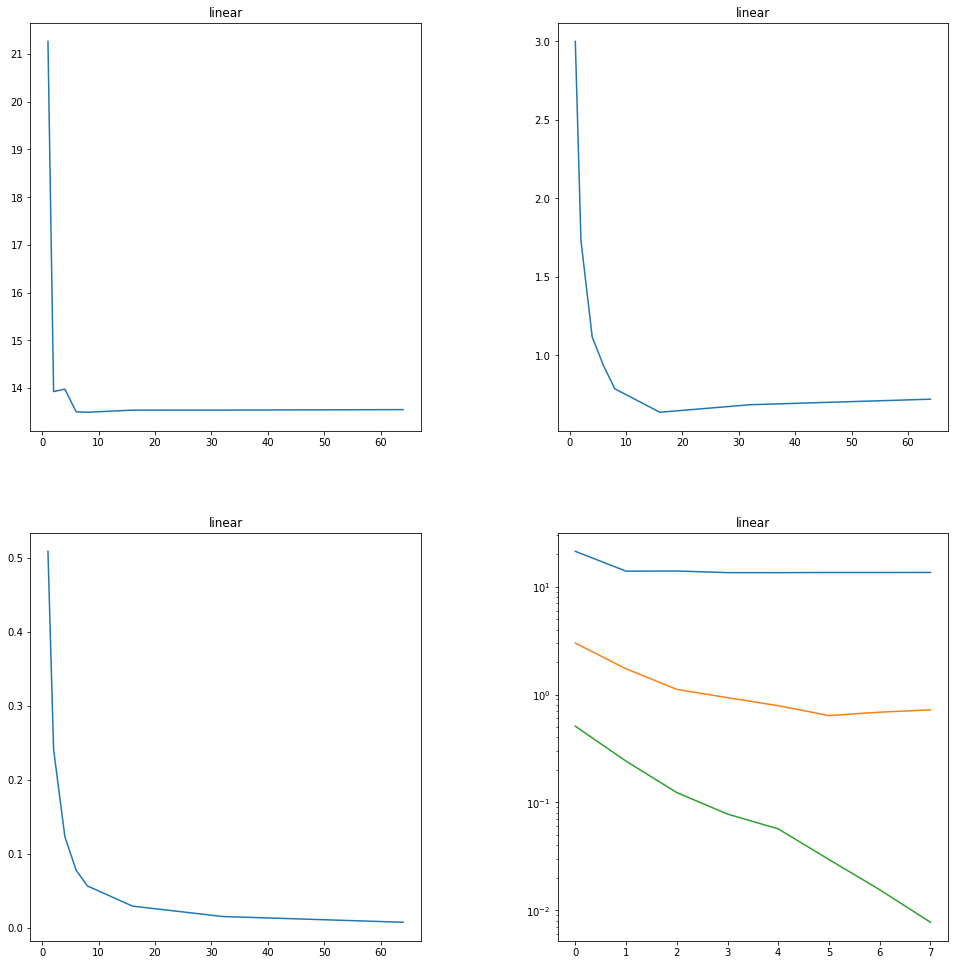

In [149]:
plot_benchmarks(data)

## Daily Messages Volume

In [ ]:
plt.figure(figsize=(8,8))
fig = plt.subplot()
fig.plot(dates, date_volume)
fig.figure.autofmt_xdate()
myFmt = DateFormatter("%Y-%m-%d")
fig.xaxis.set_major_formatter(myFmt)
plt.show()

## Benchmarks - May 2010 - Dataset

In [51]:
path = "02-report/output/"
files = sorted(list(os.walk(path))[0][2])
year = pd.read_csv("02-report/volume.csv")
year['week'] = [str(datetime.strptime(i,'%m/%d/%y').date()) for i in year['week']]

In [52]:
orderedfile = [{int(files[i].split("-")[1].split("_")[0]):files[i]} for k in range(5) for i in range(k,40,5)]

In [53]:
df1 = []
df2 = []
for item in orderedfile:
    k = list(item.keys())[0]
    thread = item[k].split("-")[0]
    f = open(path+item[k],'r')
    d = f.readlines()
    header = d[7][:-1]
    vol = pd.DataFrame([i.split(",") for i in d[1:6]],columns=['date','volume'])
    vol['threads'] = thread
    mtrs = pd.DataFrame([i.split(",") for i in d[8:]],columns=header.split(','))
    mtrs['threads'] = thread
    mtrs['date'] = vol.date
    df1.append(mtrs)
    df2.append(vol)
f.close()

In [54]:
metrics = pd.concat(df1)
metrics['volume_time'] = [float(i) for i in metrics['volume_time']]
metrics = metrics.reset_index()
metrics['threads'] = [int(i) for i in metrics['threads']]
metrics['date'] = [str(datetime.strptime(str(i),'%Y%m%d').date()) for i in metrics['date']]
del metrics['index']

In [55]:
metrics.read_time = metrics.read_time.astype(float)
metrics.search_time = metrics.search_time.astype(float)
metrics.threads = metrics.threads.astype(int)
metrics.total_msgs = metrics.total_msgs.astype(int)
metrics.volume_time = metrics.volume_time.astype(float)

In [56]:
metrics.head(8)

,total_msgs,read_time,search_time,volume_time,threads,date
0,50846717,150.680,25.70200,5.252070,1,2010-05-02
1,50846717,106.038,4.84808,0.275994,16,2010-05-02
2,50846717,108.555,15.09720,2.433970,2,2010-05-02
3,50846717,106.644,4.06246,0.138209,32,2010-05-02
4,50846717,104.643,10.50430,1.084580,4,2010-05-02
5,50846717,111.118,8.60050,0.739922,6,2010-05-02
6,50846717,106.865,4.82214,0.070694,64,2010-05-02
7,50846717,105.937,6.38752,0.551850,8,2010-05-02


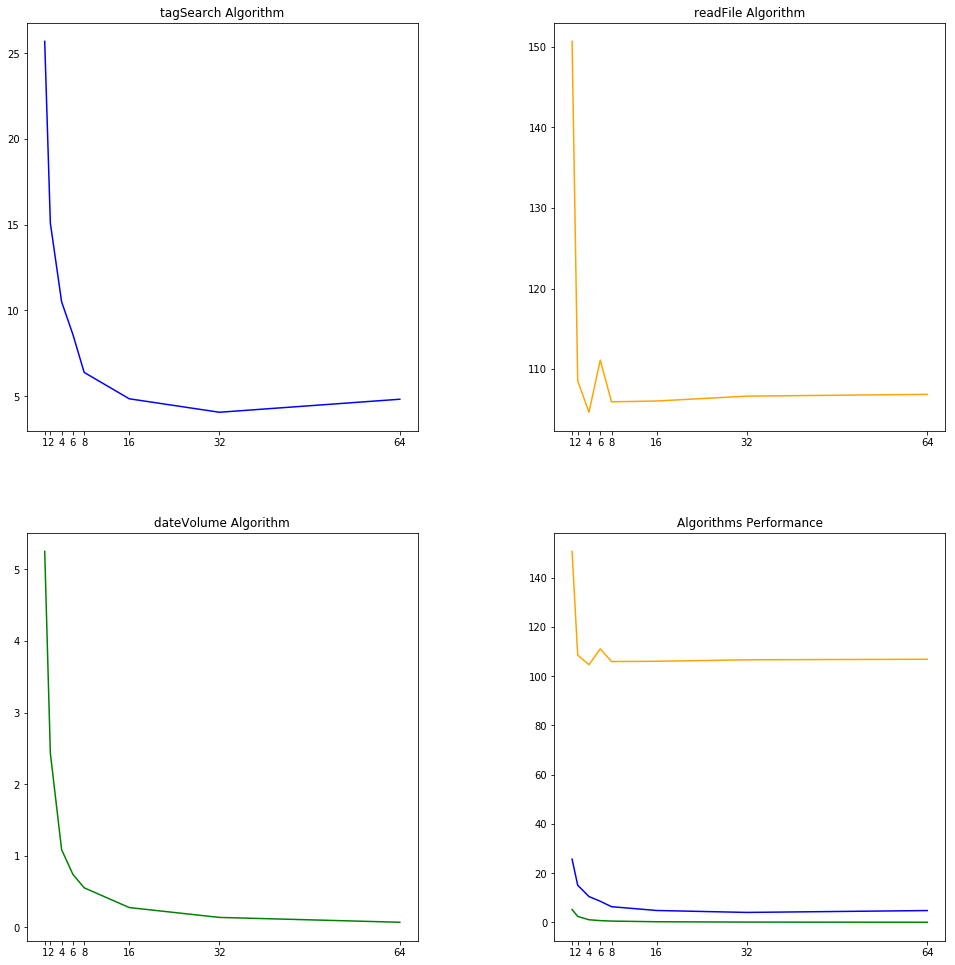

In [57]:
df = metrics[metrics.date=='2010-05-02'].sort_values('threads')
plot_benchmarks(df)

In [58]:
volume = pd.concat(df2)
volume['date'] = [str(datetime.strptime(i,'%Y%m%d').date()) for i in volume['date']]
volume['volume'] = [int(i) for i in volume['volume']]

In [59]:
display(volume[volume.date=="2010-05-04"], 
        volume[volume.date=="2010-05-05"],
        volume[volume.date=="2010-05-06"])

,date,volume,threads
2,2010-05-04,8265188,1
2,2010-05-04,8265188,16
2,2010-05-04,8265188,2
2,2010-05-04,8265188,32
2,2010-05-04,8265188,4
2,2010-05-04,8265188,6
2,2010-05-04,8265188,64
2,2010-05-04,8265188,8
,date,volume,threads
3,2010-05-05,8316943,1


In [60]:
may = volume[volume.threads=='1']

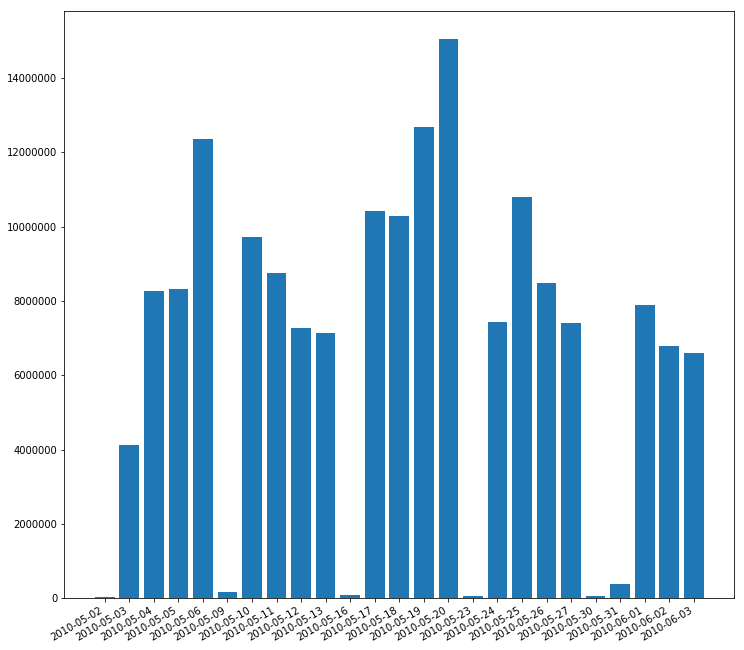

In [61]:
x = list(range(len(may['date'])))
y = may['volume']
plt.figure(figsize=(12,12))
fig = plt.subplot()
fig.bar(x,y)
plt.xticks(x, list(may['date']))
fig.figure.autofmt_xdate()
fig.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

In [62]:
year [(year['week']>"2010-04-02")&(year['week']<="2010-06-25")]

,week,lines
13,2010-04-09,15046450
14,2010-04-16,17452913
15,2010-04-23,24877428
16,2010-04-30,32124000
17,2010-05-07,50846717
18,2010-05-14,43593190
19,2010-05-21,62586111
20,2010-05-28,41407982
21,2010-06-04,31720486
22,2010-06-11,46319407


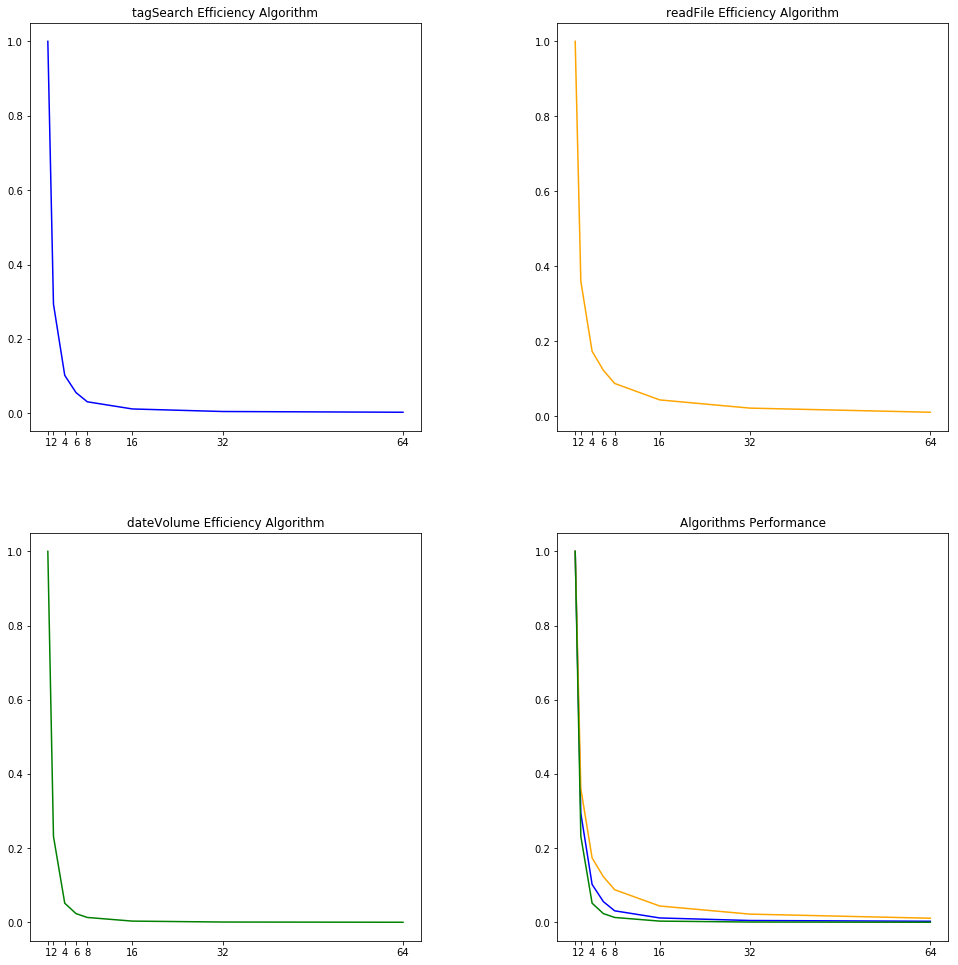

In [95]:
benchmarks(df)

In [63]:
year.lines.mean()

27094889.46153846

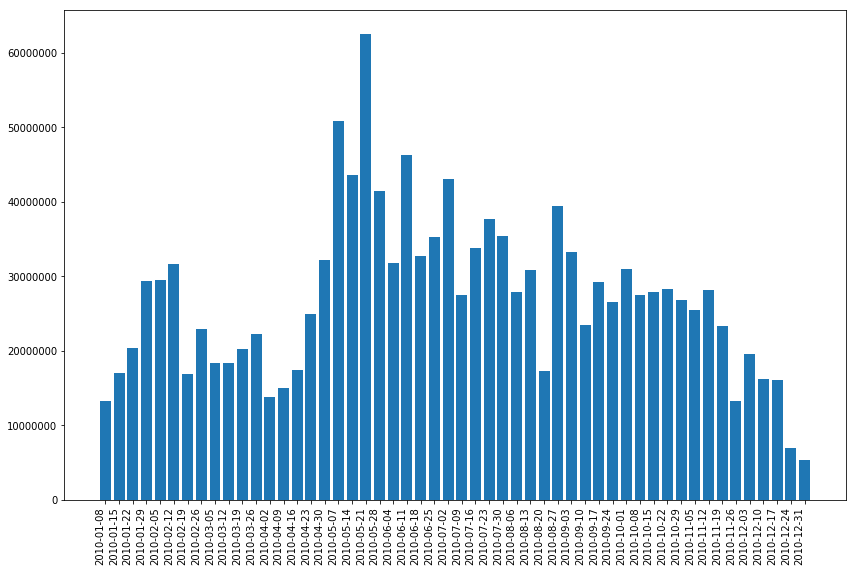

In [37]:
x = list(range(len(year['week'])))
y = year['lines']
plt.figure(figsize=(14,10))
fig = plt.subplot()
fig.bar(x,y)
plt.xticks(x, list(year['week']))
fig.figure.autofmt_xdate(rotation=90)
fig.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

# Spark/Hadoop Approach on Wrangler

### Notebook Spark Setup 

The package findspark is very important as it will help to find Spark in the system. If the enviroment variable SPARK_HOME is setup then just need to run `findspark.find()`. It is also possible to give the direct path to the find Spark using the `findspark.init(/path/to/spark/)`

In [ ]:
import findspark 
findspark.init('/usr/lib/spark', edit_profile=True)
findspark.find()

After finding spark then it is possible to `import pyspark` and start the `SparkContext`

In [ ]:
import pyspark
sc = pyspark.SparkContext(appName="fixAnalyzer")

In [17]:
path = "/data/05191/jlroo/raw"
files = list(os.walk(path))[0][2]
hdfs = "hdfs://" + "/user/jlroo/cme/"

In [ ]:
wkfiles = {int(i.split("_")[-2]):sc.textFile(hdfs + i) for i in files}
data = OrderedDict(sorted(wkfiles.items(), key=lambda t: t[0]))

In [ ]:
count = {key:data[key].count() for key in data}

In [ ]:
df = data['20100409'].map(lambda r: Row(r)).toDF(["line"])